Problem 1: Draw the moral graph, triangulated graph and the junction tree. 
Explain why the "running intersection property" is satisfied in your junction tree.

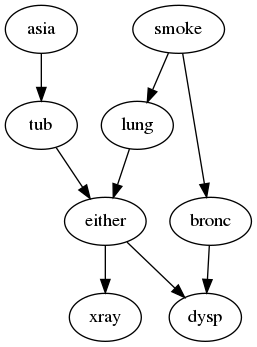

In [1]:
import numpy as np
import pydot as p
from IPython.display import display, Image

(bayes_net,) = p.graph_from_dot_file('graph.dot')
bayes_net.write_png('directional.png')
Image('directional.png')

Step 1: Moralize graph
To moralize the graph, the direction of the graph will be ommitted. After that, any parent nodes of a common child (forming a v-shape) will have an add created between them. 

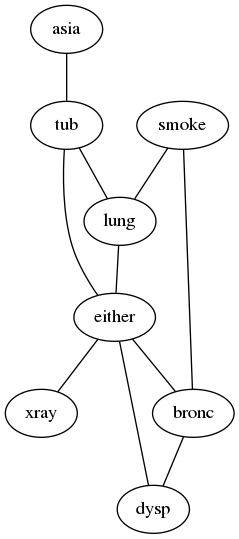

In [2]:
bayes_net.set_type('graph')
bayes_net.add_edge(p.Edge('tub','lung'))
bayes_net.add_edge(p.Edge('either','bronc'))
bayes_net.write_png('moralize.png')
Image('moralize.png')

Step 2: triangulate graph
make sure any cycle >= 4 forms a chordal. If it doesn't, an edge to two non-adjacent nodes will be created to till it becomes a chordal. 

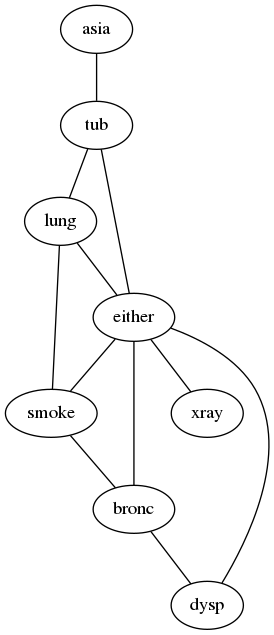

In [3]:
bayes_net.add_edge(p.Edge('either','smoke'))
bayes_net.write_png('triangulate.png')
Image('triangulate.png')

#TODO: implement triangulation checking

Step 3: Junction Tree Construction

Taking the triangulated graph, the junction tree can be constructed. The maximal cliques can be taken from this graph. Looking at the nodes with the highest degree, we can take that node first and form a subgraph of this clique. This can be done recursively to all of the nodes. When that is finished, the edges can be formed into intermediary nodes to represent seperators which include the intersected set of the connected nodes. A form of the Bron–Kerbosch algorithm can be used to create the maximale cliques likewise. 

For example, the ordering can be done this way:

{Smoke, Either, Bronc}
{Smoke, Either, Lung}
{Bronc, Either, Dysp}
{Lung, Either, Tub}
{Either, Xray}
{Asia, Tub}

Then, check all of the values of the intersections and create nodes for them. These will be the seraptors that are the connection between all of the cliques:

{Smoke, Either}
{Bronc , Either}
{Lung, Either}
{Either}
{Tub}

How do we know the resultant graph satisfies the running intersection property?
The running intersection property states that "for each pair of clusters B and C that contain i, each cluster on the unique path between B and C also contains i." The property is known to be satisfied, because all of the seperators we used are i and the separoters are positioned to form a connection between every cluster B and C.


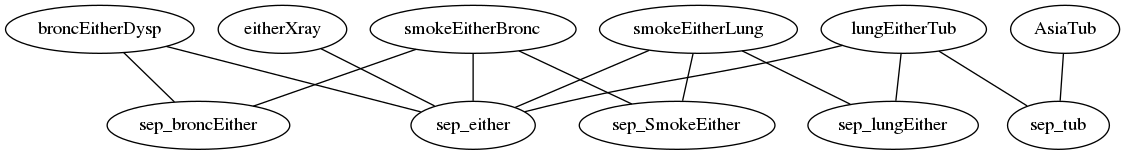

In [4]:
junction_dot = '''graph {
    smokeEitherBronc -> sep_SmokeEither 
    smokeEitherBronc -> sep_broncEither
    smokeEitherBronc -> sep_either
    
    smokeEitherLung ->  sep_SmokeEither 
    smokeEitherLung ->  sep_lungEither
    smokeEitherLung ->  sep_either
    
    broncEitherDysp ->  sep_broncEither
    broncEitherDysp ->  sep_either
    
    lungEitherTub ->   sep_lungEither
    lungEitherTub ->   sep_either
    lungEitherTub ->   sep_tub
    
    AsiaTub -> sep_tub
    eitherXray -> sep_either
} '''

(junction,) = p.graph_from_dot_data(junction_dot)
junction.write_png('junction.png')
Image('junction.png')


In [5]:
#Step 3: Construct junction tree
#clique tree construction and seps set
#Explain why the "running intersection property" is satisfied in your junction tree.

#adjacency matrix construction row == column
adj_matrix = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                         [1, 0, 1, 1, 0, 0, 0, 0],
                         [0, 1, 0, 1, 1, 0, 0, 0],
                         [0, 1, 1, 0, 1, 1, 1, 0],
                         [0, 0, 1, 0, 0, 0, 1, 0],
                         [0, 0, 0, 1, 0, 0, 0, 0],
                         [0, 0, 0, 1, 1, 0, 0, 0],
                         [0, 0, 0, 1, 0, 0, 1, 0],
    ])

#neighbor sets for each vertex

#TODO: 
#if a variable is in two cliques then it is in every clique along the path
#connecting the two cliques.
#Define C to be the set of maximal cliques, meaning that no member of C is
#a subset of another member of C.
#Bron–Kerbosch algorithm
#def bron_ker_alg(r, p, x):
#    asia_nset = set(['tub'])
#    tub_nset = set(['asia', 'lung', 'either'])
#    lung_nset = set(['tub', 'either', 'smoke'])
#    either_nset = set(['tub', 'lung', 'smoke', 'xray', 'bronc'])
#    smoke_nset = set(['lung', 'bronc'])
#    xray_nset = set(['either'])
#    bronc_nset = set(['either', 'smoke'])
#    dysp_nset = set(['either', 'bronc'])
    
#    if(len(p) == 0 and len(x) ==0): #p, x are empty
#        print('r is maximal clique')
#    else:
#        for v in p:
#            rtemp = r
#            rtemp.add(v)
#            ptemp = v + '_nset'
#            xtemp = v + '_nset'
#            print(p)
#            #p.remove(v)
            #x.add(v)
#            bron_ker_alg(rtemp, ptemp, xtemp)

#r = set()#empty set
#x = set()#empty set
#p = set(['asia','tub','lung','either','smoke','xray','bronc','dysp'])
#bron_ker_alg(r, p, x)

Problem 2: Describe how the different terms on the right hand side of 

p(V) = p(a) p(t|a) p(s) p(l|s) p(b|s) p(e|t,l) p(d|e,b) p(x|e) 

are distributed among the different juction tree clusters. 
Write out the messages using these terms and verify that 
the message passing algorithm indeed gives the cluster marginals. 
Write out the messages using these terms and verify that the message 
passing algorithm indeed gives the cluster marginals.




The distribution of these terms are done by following the message passing protocol. Taking each cluster, we can start at a 'root' node. There is an upward stream and a downward stream in the process, 'collect' and 'distribute' collectively. a node, starting with the root, will call collect and recursively call collect on all of its children. This will pass messages to all of the parent nodes from the children that were called. After that, the distribute process will begin. Each parent node will send a message to it's child. This will be done recursively. Specifically, we will perform the belief propagation algorithm to get the marginal distribution of the  clusters on the RHS. 

for each term, we take the product of all incoming messages to marginalize:

p(xray|either) = m(smokeEitherLung) * m(smokeEitherBronc) * m(BroncEitherDysp) * m(lungEitherTub)

p(dysp|either,bronc) = m(smokeEitherLung) * m(smokeEitherBronc) * m(XrayEither) * m(lungEitherTub)

p(either|tub,lung) = m(asiaTub) * 

p(bronc|smoke) = 

p(lung|smoke) =

p(smoke) = 

p(tub|asia) =

p(asia) =


Sources:
https://en.wikipedia.org/wiki/Bron%E2%80%93Kerbosch_algorithm
https://docs.python.org/3.5
https://www.cs.princeton.edu/courses/archive/spr09/cos513/scribe/lecture05.pdf
https://github.com/erocarrera/pydot
https://en.wikipedia.org/wiki/Moral_graph
file:///home/cam/Documents/dev/cse455/books/A%20Short%20Course%20in%20Graphical%20Models.pdf
https://pythonhaven.wordpress.com/tag/pydot/
https://ipython.readthedocs.io/en/stable/
Building Probabilistic Graphical Models with Python
https://github.com/eBay/bayesian-belief-networks
http://www.numpy.org/
https://en.wikipedia.org/wiki/Belief_propagation